# Conditional SSP diffusion

This code requires the dev branch of score_models to work

```bash
git clone https://github.com/AlexandreAdam/score_models.git
cd score_models
git checkout dev
pip install .
```

Or if training locally on a Mac where MPS is required

```bash
git clone https://github.com/sachapf/score_models.git
cd score_models
git checkout dev-mps
pip install .
```

In [25]:
from conditional_sfr_diffusion import train_conditional, sample_conditional_model
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
# This code requires the dev branch of score_models to run properly
from score_models import ScoreModel


DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
torch.set_default_device(DEVICE)
dtype = torch.float32
torch.set_default_dtype(dtype)
checkpoints_folder = '/checkpoints'
plot_folder = '/plots'

## Training the model
The models have already been trained for several days, so here we can train them for a few more epochs as a test.

The model in folder `conditional_folder_tm_64` is trained on mock data: linear SSPs of length 64 conditioned on time-metallicity pairs.  
The conditional function is `f(x)=tx+z` where x is a 64 dimensional vector with values from 0.1 to 6.4.

The model in folder `conditional_folder_fsps` is trained on data generated from fsps (with default configuration), conditioned on time-metallicity pairs.  
The SSPs are 5994-dimensional with 0 padding to make them 6000-dimensional.  
The data in the folder is only a subset of the data used to train the model  
<span style="color:red">Training this model locally might crash because of the size of the data</span>.

If you are testing locally on a Mac, this will only work if MPS is set up

In [ ]:
# name of folder that contains the data, number of epochs to train for, whether or not to generate samples, whether the model is trained on the simple linear test SSPs
model_64 = train_conditional("conditional_folder_tm_64", epochs=5, sample=False, linear_test=True)

Loaded checkpoint 5746 from checkpoints.
Using Karras EMA with ema lengths [0.13]
Resumed training from checkpoint 5746.


Epoch 5 | Cost: 2.6e-01 | time per step 0.3364 s |: 100%|██████████| 5/5 [00:58<00:00, 11.73s/it]

Finished training after 0.016 hours.


In [ ]:
# Train a new model from scratch
# This data is conditioned only on time and generates linear SSPs that are 4-dimensional, for simplicity
# f(x) = tx
# plots will be generated in the plots folder
# 10k epochs will take around an hour using MPS. The number of epochs can be reduced as a test but the results won't be accurate
new_model_test = train_conditional("new_conditional_test_time_4", epochs=10000, sample=True, linear_test=True, time_only=True)

/Users/sacha/Documents/Research/Lighthouse/Conditional_start/cond-env/lib/python3.9/site-packages/torch/utils/_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Using Karras EMA with ema lengths [0.13]
Provided path new_conditional_test_time_4/checkpoints is not a valid directory. Can't load checkpoint.


Epoch 10 | Cost: 1.9e+00 | time per step 0.2710 s |:   0%|          | 10/10000 [00:05<1:09:07,  2.41it/s]

Saved hyperparameters to new_conditional_test_time_4/checkpoints


Epoch 10000 | Cost: 1.7e-01 | time per step 0.2267 s |: 100%|██████████| 10000/10000 [44:47<00:00,  3.72it/s]


Finished training after 0.747 hours.


t=0.0002 | sigma=0.002 | x=0.4±0.2: 100%|██████████| 5000/5000 [02:25<00:00, 34.46it/s]


The conditional train index is 48


t=0.0002 | sigma=0.002 | x=0.3±0.2: 100%|██████████| 5000/5000 [02:24<00:00, 34.53it/s]


The conditional test index is 19


<Figure size 640x480 with 0 Axes>

In [ ]:
# get more samples from the newly created model
# The plots will be saved in the plots folder
sample_conditional_model("new_conditional_test_time_4", time_only=True, linear_test=True)

In [ ]:
# Depending on the computer, this might crash the kernel, so I don't recommend running this
# model_fsps = train_conditional("new_conditional_test_time_4", epochs=5, sample=False, linear_test=False, time_only=False)

## Sampling from the model

The model in folder `conditional_folder_tm_64` is trained on mock data: linear SSPs of length 64 conditioned on time-metallicity pairs.  
The conditional function is `f(x)=tx+z` where x is a 64 dimensional vector with values from 0.1 to 6.4.

The model in folder `conditional_folder_fsps` is trained on data generated from fsps (with default configuration), conditioned on time-metallicity pairs.  
The SSPs are 5994-dimensional with 0 padding to make them 6000-dimensional.

In [26]:
# Loads the model from the checkpoints in save_directory and generates a sample comparisons
# The time, metallicity and SSPs are taken from the training and test datasets
# num_tests is the number of different (time, metallicity) conditional pairs to sample with
# num_samples is the number of samples to generate for each conditional pair
# This function only works for models trained with time AND metallicity, doesn't work for just time or just metallicity
def generate_samples(save_directory, steps=1000,  num_tests=5, num_samples=5, log_scale=False):
    checkpoints_directory = save_directory + checkpoints_folder
    plot_dir = save_directory + plot_folder
    plotted_files = os.listdir(plot_dir)

    train_data = torch.load(save_directory + '/train_dataset.pt', map_location=DEVICE, weights_only=True)
    test_data = torch.load(save_directory + '/test_dataset.pt', map_location=DEVICE, weights_only=True)
    time_train = torch.load(save_directory + '/time_train.pt', map_location=DEVICE, weights_only=True)
    metal_train = torch.load(save_directory + '/metal_train.pt', map_location=DEVICE, weights_only=True)
    time_test = torch.load(save_directory + '/time_test.pt', map_location=DEVICE, weights_only=True)
    metal_test = torch.load(save_directory + '/metal_test.pt', map_location=DEVICE, weights_only=True)

    # wavelengths for plotting the SSPs
    # ensure this file exists or else the default linear wavelengths will be used
    if os.path.exists(save_directory + "/wavelengths.pt"):
        wave = torch.load(save_directory + "/wavelengths.pt", weights_only=True)
        wave = wave.cpu().numpy()
    else:
        print("Linear wavelengths used")
        wave = torch.arange(0, train_data.shape[-1])
        wave = wave.cpu().numpy()

    model = ScoreModel(checkpoints_directory=checkpoints_directory)

    train_samples = torch.zeros(num_tests, num_samples, train_data.shape[-1])
    test_samples = torch.zeros(num_tests, num_samples, test_data.shape[-1])
    train_true = torch.zeros(num_tests, train_data.shape[-1])
    test_true = torch.zeros(num_tests, test_data.shape[-1])

    for i in range(num_tests):
        # get a random train point
        train_idx = np.random.randint(0, len(train_data))
        ssp_train = train_data[train_idx]
        t_train = time_train[train_idx]
        z_train = metal_train[train_idx]

        # get a random test point
        test_idx = np.random.randint(0, len(test_data))
        ssp_test = test_data[test_idx]
        t_test = time_test[test_idx]
        z_test = metal_test[test_idx]

        # Generate the samples conditioned on the train and test time-metallicities
        train_samps = model.sample(t_train.repeat(num_samples, 1), z_train.repeat(num_samples, 1), shape=[num_samples, 1, ssp_test.shape[-1]], steps=steps).squeeze()
        test_samps = model.sample(t_test.repeat(num_samples, 1), z_test.repeat(num_samples, 1), shape=[num_samples, 1, ssp_test.shape[-1]], steps=steps).squeeze()

        train_samples[i] = train_samps.reshape(num_samples, len(wave))
        test_samples[i] = test_samps.reshape(num_samples, len(wave))
        train_true[i] = ssp_train.squeeze()
        test_true[i] = ssp_test.squeeze()

    # plot all train samples vs wave
    train_true_np = train_true.reshape(num_tests, len(wave)).cpu().numpy()
    test_true_np = test_true.reshape(num_tests, len(wave)).cpu().numpy()

    # The pairs of colours are similar so it's obvious which samples should match which true SSP
    colours = ['red', 'blue', 'darkviolet', 'green', 'orange']
    truth_colours = ['pink', 'cyan', 'violet', 'lime', 'yellow']

    # ensuring we don't overwrite the same file
    min_idx = 0
    while plotted_files.count('conditional_comparison_' + str(min_idx) + '_train_sample.png') > 0:
        min_idx += 1

    # Depending on the data, you might want to plot in log scale
    # for example, fsps SSPs should be plotted in log scale
    if log_scale:
        plt.xscale('log')

    for i in range(num_tests):
        plt.plot(wave, train_true_np[i], color=truth_colours[i % len(truth_colours)], label='True train %s' % i)

    for i in range(num_tests):
        for j in range(num_samples):
            samp = train_samples[i][j].cpu().numpy()
            plt.plot(wave, samp, color=colours[i % len(colours)], linestyle='dotted')

    plt.legend()
    plt.savefig(plot_dir + '/conditional_comparison_' + str(min_idx) + '_train_sample.png')
    plt.show()
    plt.clf()

    # ensuring we don't overwrite the same file
    min_idx = 0
    while plotted_files.count('conditional_comparison_' + str(min_idx) + '_test_sample.png') > 0:
        min_idx += 1

    if log_scale:
        plt.xscale('log')

    for i in range(num_tests):
        plt.plot(wave, test_true_np[i], color=truth_colours[i % len(truth_colours)], label='True test %s' % i)

    for i in range(num_tests):
        for j in range(num_samples):
            samp = test_samples[i][j].cpu().numpy()
            plt.plot(wave, samp, color=colours[i % len(colours)], linestyle='dotted')

    plt.legend()
    plt.savefig(plot_dir + '/conditional_comparison_' + str(min_idx) + '_test_sample.png')
    plt.show()
    plt.clf()

    return train_samples, test_samples, train_true, test_true, wave

Loaded checkpoint 5746 from checkpoints.


t=0.001 | sigma=0.002 | x=5±3: 100%|██████████| 1000/1000 [00:47<00:00, 21.13it/s]    
t=0.001 | sigma=0.002 | x=6±3: 100%|██████████| 1000/1000 [00:41<00:00, 23.83it/s]    
t=0.001 | sigma=0.002 | x=4±2: 100%|██████████| 1000/1000 [00:41<00:00, 23.99it/s] 
t=0.001 | sigma=0.002 | x=2±0.4: 100%|██████████| 1000/1000 [00:39<00:00, 25.43it/s] 
t=0.001 | sigma=0.002 | x=3±1: 100%|██████████| 1000/1000 [00:38<00:00, 25.86it/s]    
t=0.001 | sigma=0.002 | x=3±1: 100%|██████████| 1000/1000 [13:23<00:00,  1.24it/s]    
t=0.001 | sigma=0.002 | x=0.7±0.2: 100%|██████████| 1000/1000 [00:45<00:00, 22.19it/s] 
t=0.001 | sigma=0.002 | x=7±3: 100%|██████████| 1000/1000 [00:41<00:00, 23.86it/s] 
t=0.001 | sigma=0.002 | x=6±3: 100%|██████████| 1000/1000 [00:40<00:00, 24.98it/s]    
t=0.001 | sigma=0.002 | x=5±2: 100%|██████████| 1000/1000 [00:40<00:00, 24.78it/s] 


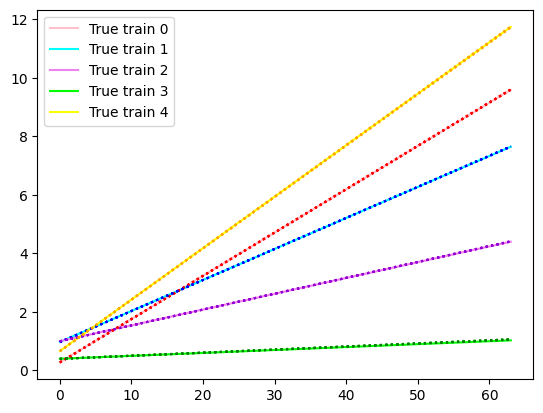

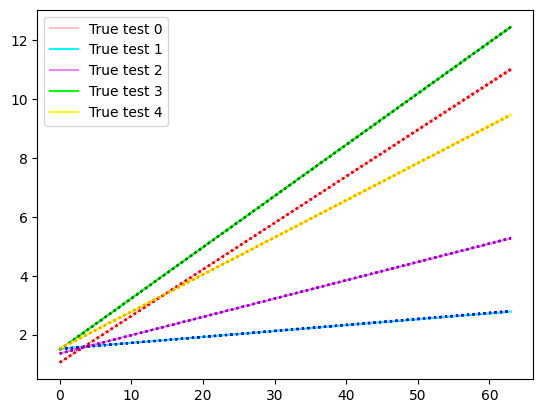

<Figure size 640x480 with 0 Axes>

In [ ]:
# The sampled generated using this model will match the training/test data
train_samples_64, test_samples_64, train_true_64, test_true_64, wave_64 = generate_samples("conditional_folder_tm_64")

Loaded checkpoint 1921 from checkpoints.


t=0.0002 | sigma=3e-26 | x=2e-05±2e-05: 100%|██████████| 5000/5000 [04:11<00:00, 19.86it/s]
t=0.0002 | sigma=3e-26 | x=0.0001±0.0002: 100%|██████████| 5000/5000 [03:58<00:00, 20.98it/s]


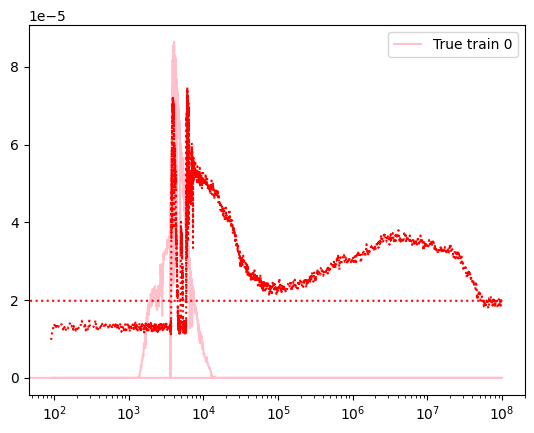

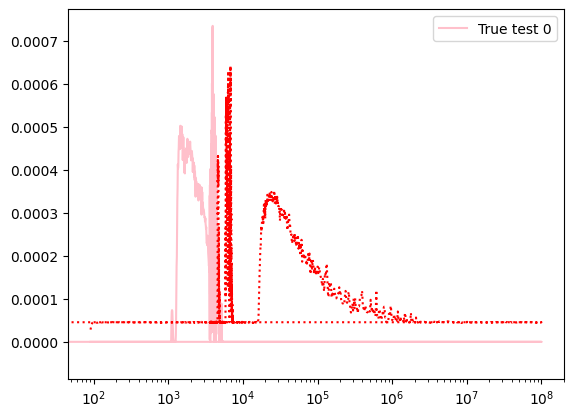

<Figure size 640x480 with 0 Axes>

In [ ]:
# This model DOESN'T generate the proper samples for the (time, metallicity) pairs
# Work needs to be done to improve it
# Generates only one test and one sample for the test
train_samples_fsps, test_samples_fsps, train_true_fsps, test_true_fsps, wave_fsps = generate_samples("conditional_folder_fsps", steps=5000, num_tests=1, num_samples=1, log_scale=True)

## Sampling test: time OR metallicity fixed

This is a sampling test for keeping time OR metallicity fixed while varying the other to ensure the model is conditioned on both  
Fixing z fixes the intercept of the plot  
Fixing t fixes the slope  

Loaded checkpoint 5747 from checkpoints.


t=0.01 | sigma=0.002 | x=6±3: 100%|██████████| 100/100 [00:06<00:00, 14.94it/s]  
t=0.01 | sigma=0.002 | x=6±3: 100%|██████████| 100/100 [00:06<00:00, 15.80it/s]     
t=0.01 | sigma=0.002 | x=3±1: 100%|██████████| 100/100 [00:06<00:00, 15.07it/s]     
t=0.01 | sigma=0.002 | x=2±0.5: 100%|██████████| 100/100 [00:06<00:00, 15.69it/s]
t=0.01 | sigma=0.002 | x=3±1: 100%|██████████| 100/100 [00:06<00:00, 15.77it/s]     


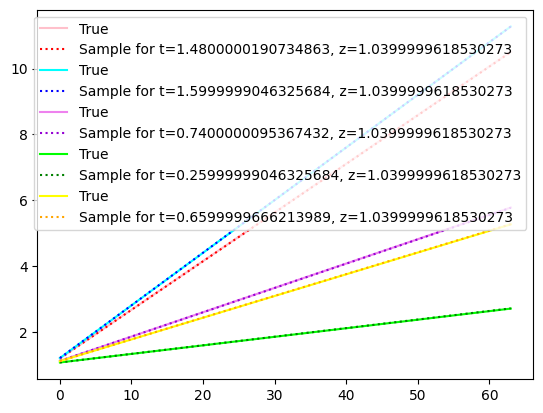

<Figure size 640x480 with 0 Axes>

In [7]:
save_directory = 'conditional_folder_tm_64'
checkpoints_directory = save_directory + checkpoints_folder
num_samples = 1
steps = 100
# Change this to False to fix time instead of the metallicity
fixed_Z = True

test_data = torch.load(save_directory + '/test_dataset.pt', map_location=DEVICE, weights_only=True)
time_test = torch.load(save_directory + '/time_test.pt', map_location=DEVICE, weights_only=True)
metal_test = torch.load(save_directory + '/metal_test.pt', map_location=DEVICE, weights_only=True)

wave = torch.arange(0, test_data.shape[-1])
wave = wave.cpu().numpy()

model = ScoreModel(checkpoints_directory=checkpoints_directory)

if fixed_Z:
    z = metal_test[np.random.randint(0, len(metal_test))]
    data = test_data[metal_test == z]
    time = time_test[metal_test == z]
    metal = metal_test[metal_test == z]
else:
    t = time_test[np.random.randint(0, len(time_test))]
    data = test_data[time_test == t]
    time = time_test[time_test == t]
    metal = metal_test[time_test == t]

num_tests = 5
indices = np.linspace(0, len(data) - 1, num_tests, dtype=int)

colours = ['red', 'blue', 'darkviolet', 'green', 'orange']
truth_colours = ['pink', 'cyan', 'violet', 'lime', 'yellow']

for i in range(num_tests):
    test_idx = indices[i]
    ssp_test = data[test_idx]
    t_test = time[test_idx]
    z_test = metal[test_idx]

    test_samp = model.sample(t_test.repeat(num_samples, 1), z_test.repeat(num_samples, 1), shape=[num_samples, 1, ssp_test.shape[-1]], steps=steps).squeeze()

    plt.plot(wave, ssp_test.cpu().numpy().squeeze(), label='True', color=truth_colours[i % len(truth_colours)])
    plt.plot(wave, test_samp.cpu().numpy(), linestyle='dotted', label='Sample for t=%s, z=%s' % (t_test.item(), z_test.item()), color=colours[i % len(colours)])

plt.legend()
plt.show()
plt.clf()



In [8]:
save_directory = 'conditional_folder_fsps'

train_data = torch.load(save_directory + '/train_dataset.pt', map_location=DEVICE, weights_only=True)
test_data = torch.load(save_directory + '/test_dataset.pt', map_location=DEVICE, weights_only=True)
time_train = torch.load(save_directory + '/time_train.pt', map_location=DEVICE, weights_only=True)
metal_train = torch.load(save_directory + '/metal_train.pt', map_location=DEVICE, weights_only=True)
time_test = torch.load(save_directory + '/time_test.pt', map_location=DEVICE, weights_only=True)
metal_test = torch.load(save_directory + '/metal_test.pt', map_location=DEVICE, weights_only=True)

In [23]:
train_data.shape
train_data_2 = train_data[::7].cpu().to(torch.device('mps'))
time_train_2 = time_train[::7].cpu().to(torch.device('mps'))
metal_train_2 = metal_train[::7].cpu().to(torch.device('mps'))

torch.save(train_data_2, save_directory + '/train_dataset.pt')
torch.save(time_train_2, save_directory + '/time_train.pt')
torch.save(metal_train_2, save_directory + '/metal_train.pt')

test_data_2 = test_data[::2].cpu().to(torch.device('mps'))
time_test_2 = time_test[::2].cpu().to(torch.device('mps'))
metal_test_2 = metal_test[::2].cpu().to(torch.device('mps'))

torch.save(test_data_2, save_directory + '/test_dataset.pt')
torch.save(time_test_2, save_directory + '/time_test.pt')
torch.save(metal_test_2, save_directory + '/metal_test.pt')
